In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

#Evaluation Metric
from sklearn.metrics import r2_score  # how well we are explaining our variants wrt regression
from sklearn.metrics import cohen_kappa_score  
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import mlxtend
import joblib
import pickle
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS   #Forward Feature Selection

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Approach01: Traditional Features**

#### **Filtering DataFrame**


In [60]:
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv("/content/drive/My Drive/IntelliTech-DataSet/EssaySet08_Features.csv", index_col =0)
df_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0.1,ID,Essay,Rater_1 Score,Rater_2 Score,Rater_3 Score,Total Score,Rater 1 Trait 1,Rater 1 Trait 2,Rater 1 Trait 3,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy
0,0,20716,A long time ago when I was in third grade I h...,18,16,NaN,34,4,4,4,...,0.362023,26.879644,110.128739,5.124865,1.818356,198,0.237126,449,0.000391,17
1,1,20717,Softball has to be one of the single most gre...,21,26,46.0,46,5,4,5,...,0.335941,66.077254,85.292453,7.466403,6.508761,259,0.300116,532,0.000511,7
2,2,20718,"Some people like making people laugh, I love ...",15,20,40.0,40,3,3,3,...,0.344118,106.268978,86.015535,5.802192,6.368023,274,0.282766,572,0.000541,7
3,3,20719,"""LAUGHTER"" @CAPS1 I hang out with my friends...",12,20,30.0,30,3,3,3,...,0.251418,58.240182,91.707794,6.086874,5.850764,206,0.269281,442,0.000407,15
4,4,20721,Well ima tell a story about the time i got @CA...,11,15,NaN,26,3,2,3,...,0.366273,42.164157,100.450854,6.972390,1.997412,137,0.193503,436,0.000270,17


In [61]:
df_train.columns

Index(['Unnamed: 0.1', 'ID', 'Essay', 'Rater_1 Score', 'Rater_2 Score',
       'Rater_3 Score', 'Total Score', 'Rater 1 Trait 1', 'Rater 1 Trait 2',
       'Rater 1 Trait 3', 'Rater 1 Trait 4', 'Rater 1 Trait 5',
       'Rater 1 Trait 6', 'Rater 2 Trait 1', 'Rater 2 Trait 2',
       'Rater 2 Trait 3', 'Rater 2 Trait 4', 'Rater 2 Trait 5',
       'Rater 2 Trait 6', 'Rater 3 Trait 1', 'Rater 3 Trait 2',
       'Rater 3 Trait 3', 'Rater 3 Trait 4', 'Rater 3 Trait 5',
       'Rater 3 Trait 6', 'Sent_Count', 'Word_Count', 'Char_Count',
       'Avg_Word_Count', 'Avg_Sentence_Length', 'Preprocessed_Essay',
       'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count',
       'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count',
       'Spelling_Mistakes_Count', 'Without_White_Spaces',
       'Essay_SpellingCorrected_LT', 'Count_Fullstops', 'Count_Exclamation',
       'Count_Comma', 'Count_Questionmark', 'Count_Hyphens',
       'Capitalization_Errors', 'Grammar_Error_Count', 

In [62]:
feats = ['Total Score', 'Sent_Count', 'Word_Count', 'Char_Count',
       'Avg_Word_Count', 'Avg_Sentence_Length', 'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count',
       'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count',
       'Spelling_Mistakes_Count','Count_Fullstops', 'Count_Exclamation',
       'Count_Comma', 'Count_Questionmark', 'Count_Hyphens',
       'Capitalization_Errors', 'Grammar_Error_Count', 'Semantic_Similarity', 'Connectivity_Index',
       'Flesch_Reading_Ease_Score', 'Flesh_Kincaid_Grade',
       'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity',
       'Lexical_Density', 'Lexical_Originality', 'Lexical_Accuracy']
df_train = df_train.loc[:, df_train.columns.isin(feats)]

In [63]:
df_train.head()

,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Syllable_Count,Difficult_Word_Count,Verb_Count,Noun_Count,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy
0,34,39,835,3421,3.282635,21.410256,740,40,138,86,...,0.362023,26.879644,110.128739,5.124865,1.818356,198,0.237126,449,0.000391,17
1,46,30,863,3963,3.687138,28.766667,942,79,125,129,...,0.335941,66.077254,85.292453,7.466403,6.508761,259,0.300116,532,0.000511,7
2,40,39,969,4397,3.672859,24.846154,1095,92,132,159,...,0.344118,106.268978,86.015535,5.802192,6.368023,274,0.282766,572,0.000541,7
3,30,30,765,3415,3.521569,25.500000,807,46,100,112,...,0.251418,58.240182,91.707794,6.086874,5.850764,206,0.269281,442,0.000407,15
4,26,26,708,2943,3.247175,27.230769,659,29,117,66,...,0.366273,42.164157,100.450854,6.972390,1.997412,137,0.193503,436,0.000270,17


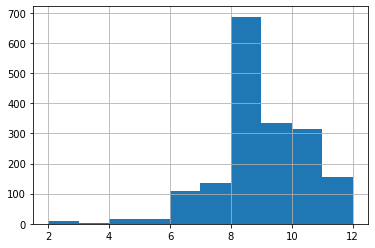

In [26]:
df_train['Total Score'].hist()

Apply transformations to make target variable more normally distributed for regression.

### **Transforming Target**
1. Log Test
2. Square Root
3. Box Cox

In [27]:
#This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.
#If the p-value > 0.05, then it is bell-curve distribution.
#Our data is clearly right skewed (Histogram)
normaltest(df_train['Total Score'].values)  

NormaltestResult(statistic=127.21536231858303, pvalue=2.3742971207847717e-28)

In [28]:
df_train['Total Score'].describe()   #Range of total score for essayset01 is 2-12, and histogram shows majority has scored between above 8.

count    1783.000000
mean        8.528323
std         1.538565
min         2.000000
25%         8.000000
50%         8.000000
75%        10.000000
max        12.000000
Name: Total Score, dtype: float64

#### Transforming Target Through Log Test

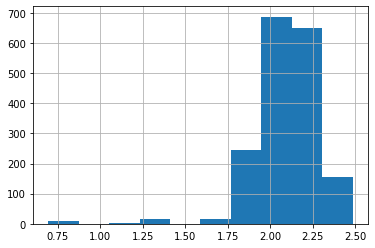

In [29]:
log_scores = np.log(df_train['Total Score'])
log_scores.hist();

In [30]:
log_scores

0       2.079442
1       2.197225
2       1.945910
3       2.302585
4       2.079442
          ...   
1778    2.079442
1779    1.945910
1780    2.079442
1781    0.693147
1782    1.945910
Name: Total Score, Length: 1783, dtype: float64

In [31]:
normaltest(log_scores)   # No significant change in p-value

NormaltestResult(statistic=967.9747627089553, pvalue=6.411371863278859e-211)

#### Transforming Through Square Root Transformation

(array([ 10.,   1.,  17.,   0.,  17., 110., 822., 334., 316., 156.]),
 array([1.41421356, 1.61920237, 1.82419117, 2.02917998, 2.23416878,
        2.43915759, 2.64414639, 2.8491352 , 3.054124  , 3.25911281,
        3.46410162]),
 <a list of 10 Patch objects>)

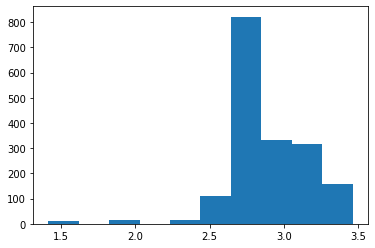

In [32]:
sqrt_scores = np.sqrt(df_train['Total Score'])
plt.hist(sqrt_scores)

In [33]:
normaltest(sqrt_scores)

NormaltestResult(statistic=456.280616698139, pvalue=8.316162831695822e-100)

####Target Transformation Through BoxCox



In [34]:
bc_result = boxcox(df_train['Total Score'])
boxcox_score = bc_result[0]
lam = bc_result[1]
lam

1.5655301197297777

In [35]:
boxcox_score.shape

(1783,)

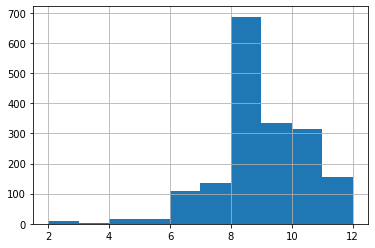

In [36]:
df_train['Total Score'].hist();

In [37]:
normaltest(boxcox_score)

NormaltestResult(statistic=17.904988846577638, pvalue=0.0001294139439387944)

Significantly more normally distributed (according to p value) than the other two distributions

### **Box Plot**
This is essentially done to visualize the outliers in the target score. This step will tell us if we need to scale our values or not.


Minimum: 5 <BR/>
Q1(25%): 8 <BR/>
Q2(50%): 8.5 <BR/>
Q3(75%): 10 <BR/>
Maximum: 12 <BR/>
The plot suggests that we have outliers in our dataset that might ruin the predictive power of our model.

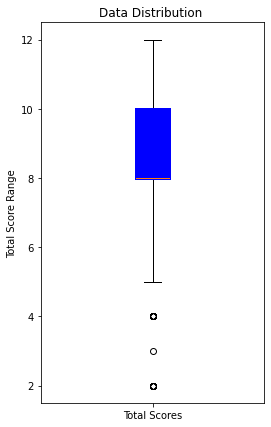

In [38]:
plt.figure(figsize =(4,7))   #Vertical box-plots gives good visualization
plt.style.use("default")
boxes = plt.boxplot(df_train['Total Score'], labels= ['Total Scores'], patch_artist = True)
plt.title("Data Distribution ")
plt.ylabel("Total Score Range")
for box in boxes['boxes']:
    box.set(color = "blue", linewidth= 3, hatch= '/', facecolor= "orange")
plt.show()

## **Model Tracking**

In [39]:
log_df = pd.DataFrame(columns = ['modelName', 'features_list', 'features_size', 'hyperparameters', 'scaling_type', 'no_of_kfolds','comments','r2-score', 'mae','cohen_kappa_score'])

In [40]:
class Logger_Regression:
    modelName = "",      # linearRegression,lasso,ridge, SVR 
    features_list = list(),
    features_size = 0,
    hyperparameters = "none",  #aplha_value, max_iteration
    scaling_type = "none",    #standard, minmax, maxabs
    no_of_kfolds = 0,
    comments = "",
    r2_score = 0,
    mae = 0,
    cohen_kappa_score = 0

    def  __init__(self, modelName, feature_list, features_size):
      self.modelName = modelName
      self.features_list = feature_list
      self.features_size = features_size

    ############################ Linear Regression ###############################
    def linearRegression_basic(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      lr = LinearRegression()
      lr.fit(X_train, y_train)
      y_pred = lr.predict(X_test)
      #print(y_pred[:10])
      #print(y_test[:10])
      self.r2_score = r2_score(y_test,y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)
      self.cohen_kappa_score=cohen_kappa_score(np.floor(y_pred), np.floor(y_test.values))
      self.add_log()

    def linearRegression_scaling(self,X,y,no_of_kfolds):
      kf = KFold(shuffle=True, random_state=72018, n_splits=no_of_kfolds)
      self.no_of_kfolds = no_of_kfolds
      scalers = {'standard': StandardScaler(),
                  'minmax': MinMaxScaler(),
                  'maxabs': MaxAbsScaler()}
        
      for scaler_label, scaler in scalers.items():
         s = scaler
         self.scaling_type = scaler_label
         lr = LinearRegression()
         estimator = Pipeline([("scaler", s), ("regression", lr)])
         predictions = cross_val_predict(estimator, X, y, cv=kf)
         self.mae = mean_absolute_error(y,predictions)
         self.r2_score = r2_score(y, predictions)*100
         self.cohen_kappa_score=cohen_kappa_score(np.rint(predictions), np.rint(y))
         self.add_log()
    
    ######################################## Lasso Regression #############################################
    def lasso_regression(self,X,y,polydegree,alphaValue):
      kf = KFold(shuffle=True, random_state=72018, n_splits=3)
      s= StandardScaler()  #since all scaling types were yielding same results
      self.scaling_type = "StandardScaler()"
      las = Lasso(alpha=alphaValue,  max_iter=10000000)
      estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree = polydegree)),
        ("scaler", s),
        ("lasso_regression", las)])
      predictions = cross_val_predict(estimator, X, y, cv=kf)
      self.r2_score = r2_score(y, predictions)*100
      self.mae = mean_absolute_error(y,predictions)
      self.cohen_kappa_score=cohen_kappa_score(np.rint(predictions), np.rint(y))
      self.add_log()
   
    ####################################### GridSearchCV ###############################################
    def gridSearchCV(self,X,y,modelName):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      if modelName == 'Ridge':
        labeler = "ridge_regression"
        model = Ridge()
      elif modelName == 'Lasso':
        labeler = "lasso_regression"
        model = Lasso()

      estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures()),
        (labeler, model)])
      # The name of paramas should be similar to that mentioned in estimators, ending with two underscores and param name.
      params = {
        'polynomial_features__degree': [1, 2, 3],
         #labeler+'__alpha': np.geomspace(4, 20, 30)
         labeler+'__alpha' : np.geomspace(1e-9, 1e0, num=10)
        }
      kf = KFold(shuffle=True, random_state=72018, n_splits=3)  
      self.no_of_kfolds =3
      grid = GridSearchCV(estimator, params, cv=kf)
      grid.fit(X_train, y_train)
      predictions = grid.predict(X_test)
      print("gridCBV best scores: " ,grid.best_score_)
      self.hyperparameters= grid.best_params_
      self.r2_score = r2_score(y_test, predictions)*100
      self.cohen_kappa_score=cohen_kappa_score(np.rint(predictions), np.rint(y_test))
      self.mae = mean_absolute_error(y_test,predictions)
      self.add_log()

    ################################# SVR ###################################################
    def svr_gridSearchCV(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      svr = SVR()
      parameters = {'kernel':['linear', 'rbf'], 'C':[1,100], 'gamma':[0.1, 0.001]}
      #parameters = {'kernel':['linear', 'rbf'], 'C':[2**-5, 2], 'gamma':[0.1, 0.001]} --Research Paper
      grid = GridSearchCV(svr, parameters)
      grid.fit(X_train, y_train)
      y_pred = grid.predict(X_test)
      # summarize the results of the grid search
      print(grid.best_score_)
      print(grid.best_estimator_)
      self.cohen_kappa_score = cohen_kappa_score(np.rint(y_pred), np.rint(y_test))
      self.r2_score = r2_score(y_test, y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)

    ################################### Random Forest ###########################################
    def randomforest_regressor(self,X,y):
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
       rf = RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = 50)
       rf.fit(X_train, y_train)
       y_pred = rf.predict(X_test)
       self.r2_score = r2_score(y_test,y_pred)*100
       self.mae = mean_absolute_error(y_test,y_pred)
       self.cohen_kappa_score=cohen_kappa_score(np.rint(y_pred), np.rint(y_test.values))
       #print("cofficeint of determination: ", rf.score())
       self.add_log()
    
    ################################# Gradient Boosting Regressor Basic #####################################
    def gbr_basic(self, X, y, learningRate=0.01, nEstimator=500, subSample=0.5 ):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      gbr = ensemble.GradientBoostingRegressor(learning_rate= learningRate, n_estimators= nEstimator, subsample= subSample)
      gbr.fit(X_train, y_train)
      y_pred = gbr.predict(X_test)
      self.hyperparamters = dict(learning_rate= learningRate, n_estimators= nEstimator, subsample= subSample)
      self.r2_score = r2_score(y_test,y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)
      self.cohen_kappa_score=cohen_kappa_score(np.rint(y_pred), np.rint(y_test.values))
      self.add_log()
      return gbr

    ################################## Gradient Boosting Regressor GridSearchCV ###############################
    def gradientBoostingRegressor(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      grid = dict()
      grid['n_estimators'] = [10, 50, 100, 500]
      grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
      grid['subsample'] = [0.5, 0.7, 1.0]
      grid['max_depth'] = [3, 7, 9]
      gbr = ensemble.GradientBoostingRegressor()
      cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
      model = GridSearchCV(estimator=gbr, param_grid=grid, n_jobs=-1, cv=cv)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      # summarize the results of the grid search
      print(model.best_score_)
      self.hyperparameters = model.best_estimator_
      print(model.best_estimator_)
      mae = mean_absolute_error(y_test, y_pred)
      mse = mean_squared_error(y_test, y_pred)
      print("Mean Absolute Error:", mae)
      print("")
      self.r2_score = r2_score(y_test,y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)
      self.cohen_kappa_score=cohen_kappa_score(np.rint(y_pred), np.rint(y_test.values))
      self.add_log()

      
    def set_comment(self,message):
      self.comments = message
    
    def add_log(self):
      print("Mean Absolute Error of "+ self.comments +"  %.3f " %self.mae)
      print("R2 score of " + self.comments + " :%.3f" %self.r2_score)
      print("Cohen Kappa score "+ self.comments +" : %.3f" %self.cohen_kappa_score)
      row = [self.modelName, self.features_list, self.features_size, self.hyperparameters, self.scaling_type, self.no_of_kfolds, self.comments ,self.r2_score, self.mae, self.cohen_kappa_score]
      log_df.loc[len(log_df)] = row

### **Linear Regression Model**


In [41]:
#basic model
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model")
data_logger.linearRegression_basic(X,y)

#boxcox variation
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with Boxcox variation")
#data_logger.linearRegression_basic(X,pd.Series(boxcox_score))


Mean Absolute Error of Vanilla Linear Regression Model  0.619 
R2 score of Vanilla Linear Regression Model :73.448
Cohen Kappa score Vanilla Linear Regression Model : 0.265


In [42]:
#scaling with no transformation
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with Scaling")
data_logger.linearRegression_scaling(X,y,3)

#scaling with target transformation
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with Scaling on Boxcox Target")
data_logger.linearRegression_scaling(X,boxcox_score,3)

Mean Absolute Error of Vanilla Linear Regression Model with Scaling  0.615 
R2 score of Vanilla Linear Regression Model with Scaling :73.712
Cohen Kappa score Vanilla Linear Regression Model with Scaling : 0.355
Mean Absolute Error of Vanilla Linear Regression Model with Scaling  0.615 
R2 score of Vanilla Linear Regression Model with Scaling :73.712
Cohen Kappa score Vanilla Linear Regression Model with Scaling : 0.355
Mean Absolute Error of Vanilla Linear Regression Model with Scaling  0.615 
R2 score of Vanilla Linear Regression Model with Scaling :73.712
Cohen Kappa score Vanilla Linear Regression Model with Scaling : 0.355
Mean Absolute Error of Vanilla Linear Regression Model with Scaling on Boxcox Target  2.071 
R2 score of Vanilla Linear Regression Model with Scaling on Boxcox Target :71.882
Cohen Kappa score Vanilla Linear Regression Model with Scaling on Boxcox Target : 0.101
Mean Absolute Error of Vanilla Linear Regression Model with Scaling on Boxcox Target  2.071 
R2 score

### **GridSearchCV (Lasso and Ridge Regression)**

In [43]:
#Lasso regression
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV")
data_logger.gridSearchCV(X,y,"Lasso")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e+02, tolerance: 1.965e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.477e+02, tolerance: 2.038e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.415e+02, tolerance: 1.898e-01

gridCBV best scores:  0.737589192074326
Mean Absolute Error of Lasso Regression + GridSearchCV  0.619 
R2 score of Lasso Regression + GridSearchCV :73.488
Cohen Kappa score Lasso Regression + GridSearchCV : 0.353


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.196e+02, tolerance: 1.898e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.662e+02, tolerance: 2.951e-01
  model = cd_fast.enet_coordinate_descent(


In [44]:
#Ridge regression
data_logger = Logger_Regression("Ridge Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Ridge regression +GridSearchCV")
data_logger.gridSearchCV(X,boxcox_score,"Ridge")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.429e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.39039e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.36975e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.429e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditione

gridCBV best scores:  0.71639686334807
Mean Absolute Error of Ridge regression +GridSearchCV  2.080 
R2 score of Ridge regression +GridSearchCV :72.196
Cohen Kappa score Ridge regression +GridSearchCV : 0.105


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.66667e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [45]:
# Training on Best Parameters
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression on Best Parameters")
data_logger.lasso_regression(X,y,1,0.0000001)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+02, tolerance: 2.783e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.264e+02, tolerance: 2.753e-01
  model = cd_fast.enet_coordinate_descent(


Mean Absolute Error of Lasso Regression on Best Parameters  0.615 
R2 score of Lasso Regression on Best Parameters :73.748
Cohen Kappa score Lasso Regression on Best Parameters : 0.357


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.743e+02, tolerance: 2.897e-01
  model = cd_fast.enet_coordinate_descent(


### **GridSearchCV (SVR)** Not working

In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Support Vector Regressor", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Support Vector Regressor with Stats features")
data_logger.svr_gridSearchCV(X,y)

### **Random Forest Regressor**

In [46]:
#Basic Model
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regressor Model")
data_logger.randomforest_regressor(X,y)

Mean Absolute Error of Random Forest Regressor Model  0.633 
R2 score of Random Forest Regressor Model :69.646
Cohen Kappa score Random Forest Regressor Model : 0.368


### **Gradient Boosting Algorithm**

In [47]:
#GridSearchCV
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Gradient Boosting Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Gradient Boosting Model")
data_logger.gradientBoostingRegressor(X,y)

KeyboardInterrupt: ignored

In [48]:
log_df.to_csv("Track01.csv")

## **Forward Feature Selection**

### **Pearson Correlation**

Text(0.5, 1.0, 'Pearson Correlation')

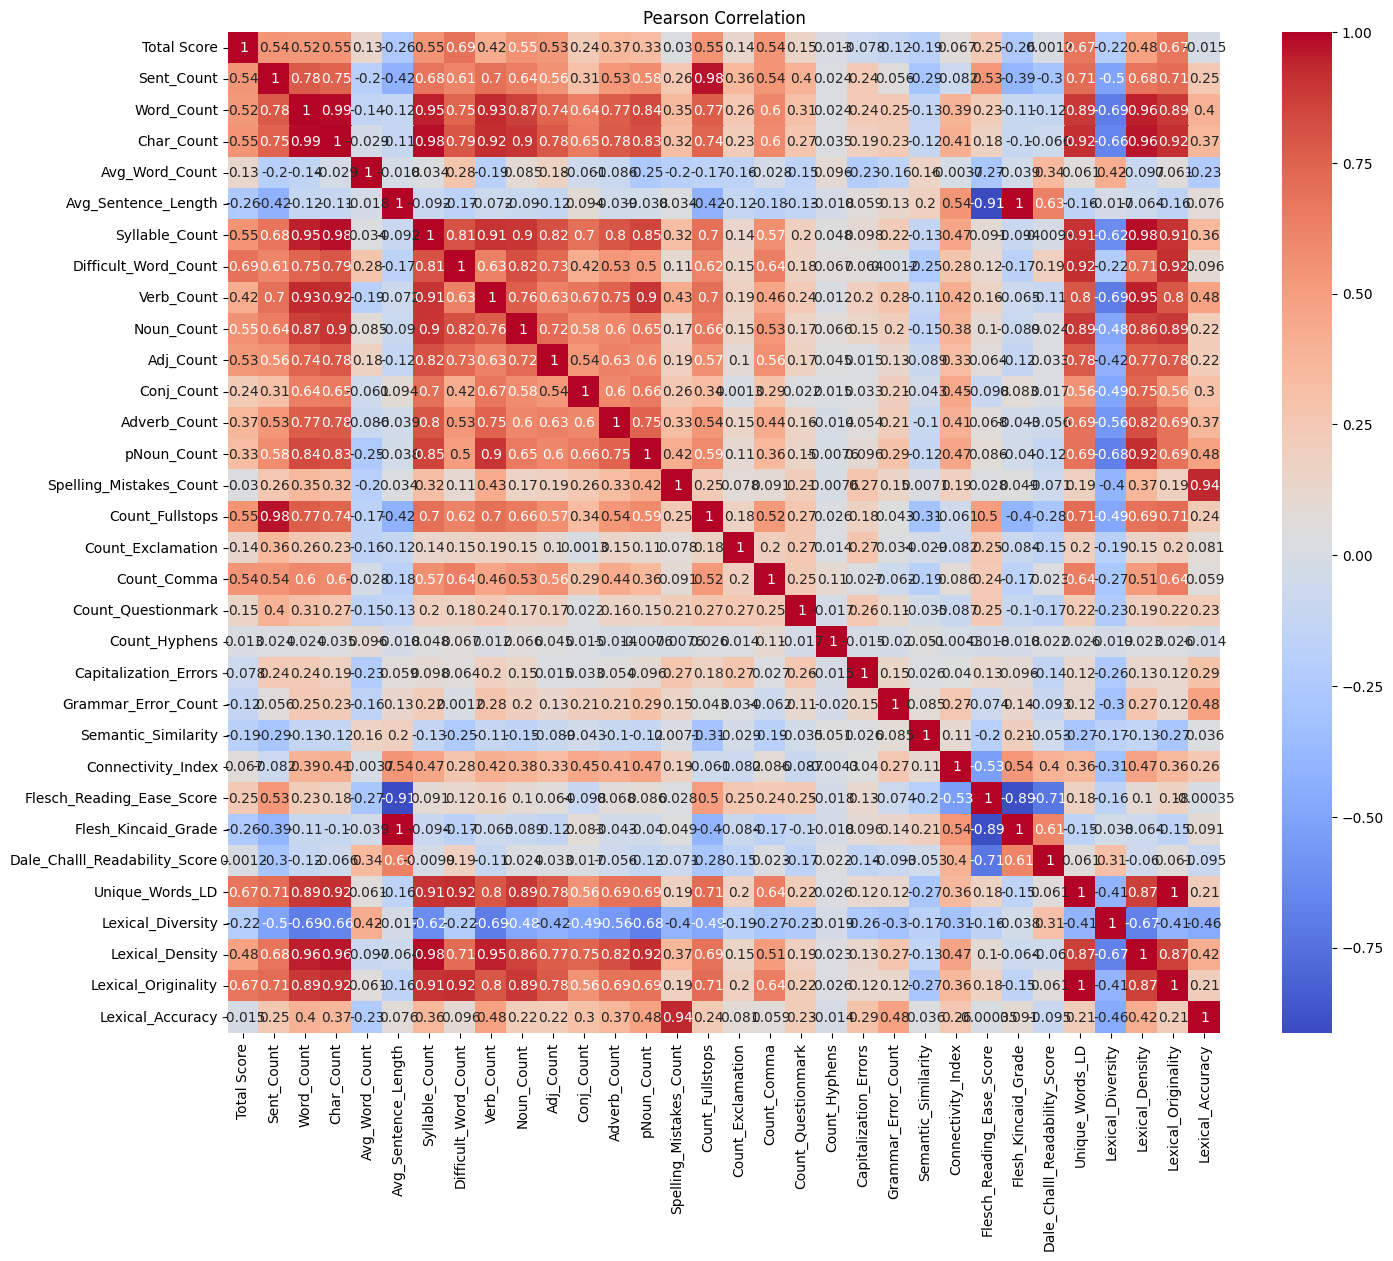

In [64]:
correlation_pearson = df_train.corr()
plt.figure(figsize=(16,13))
sns.heatmap(correlation_pearson, annot=True, cmap="coolwarm").set_title('Pearson Correlation')

### **Spearmen's Correlation** 

Text(0.5, 1.0, 'Spearmens Correlation')

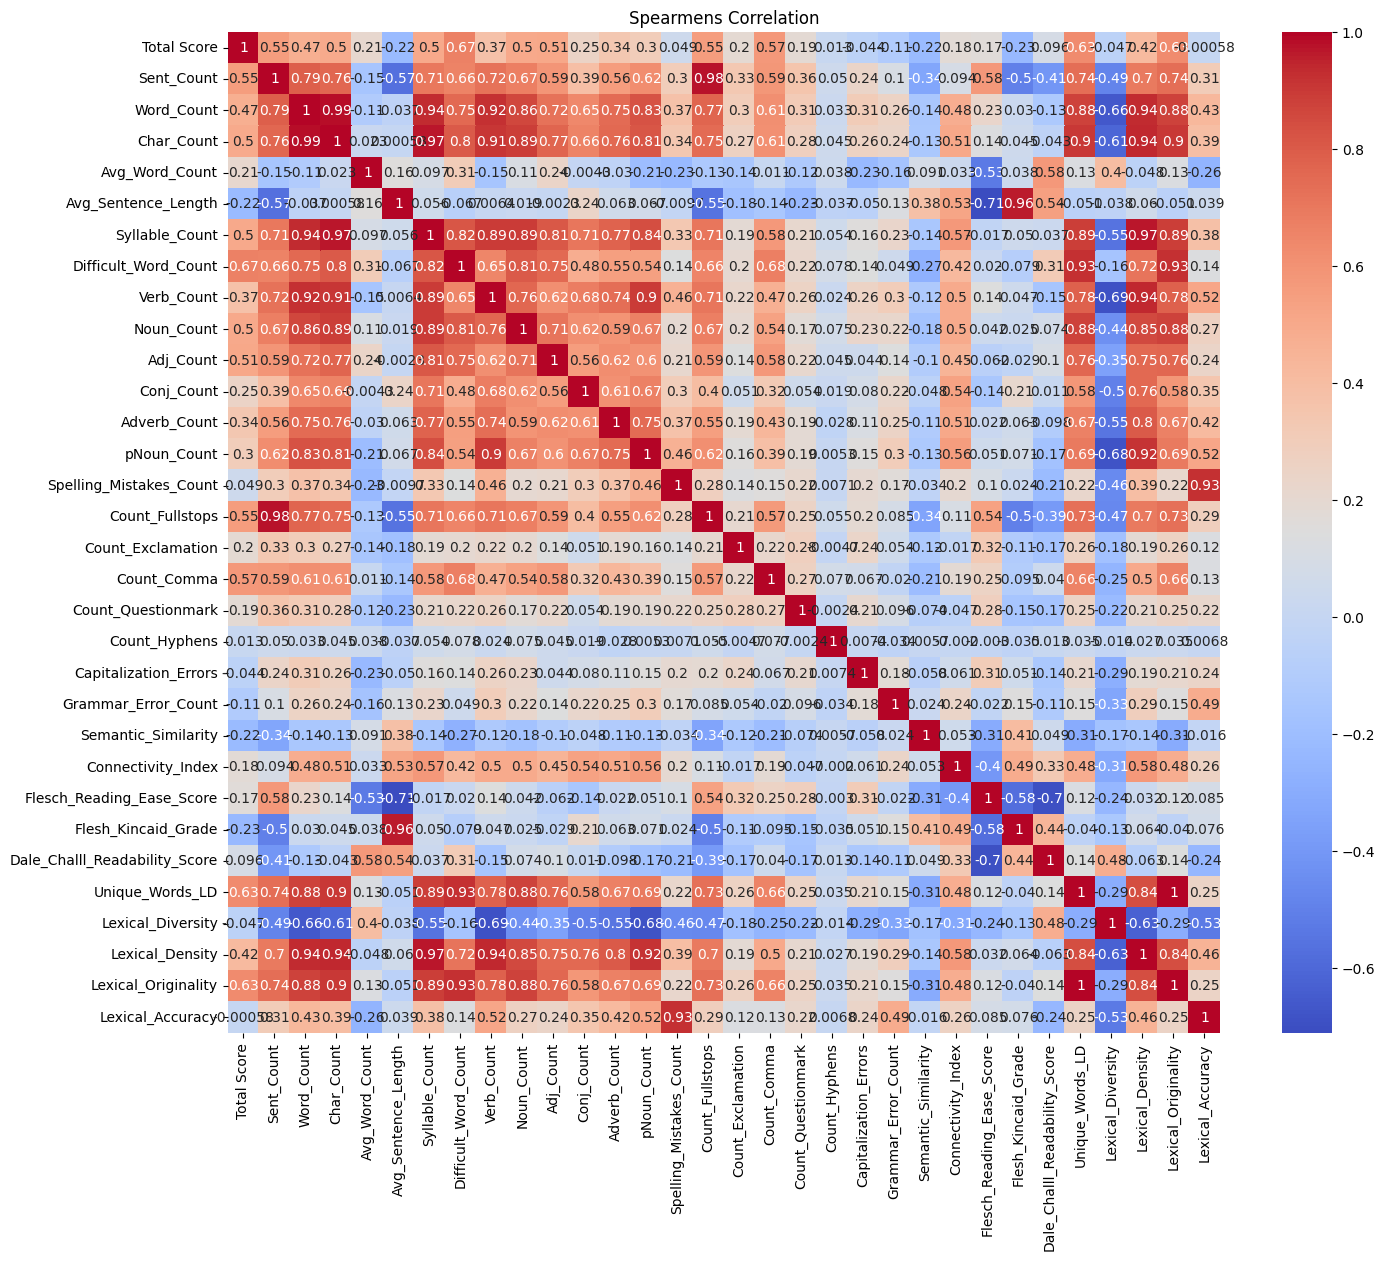

In [65]:
#The deafult method of correlation is 'Pearson' which is used when lienar relationship between variables are gauranteed.
#Pearson is sensitive to outliers
correlation_spear = df_train.corr(method='spearman')
plt.figure(figsize=(16,13))
sns.heatmap(correlation_spear, annot=True, cmap="coolwarm").set_title('Spearmens Correlation')

### **Removing Constant and Correlated Features**

#### **Removing Constant Features**


In [53]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
constant_features = [ feat for feat in X.columns if X[feat].std() == 0]
print(constant_features)

df_train.drop(labels=constant_features, axis=1, inplace=True)

[]


#### **Removing Correlated Features**

In [56]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr(method='spearman')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
corr_features = correlation(X, 0.8)
print(corr_features)
print('correlated features: ', len(set(corr_features)))
df_train.drop(labels=corr_features, axis=1, inplace=True)

{'Flesh_Kincaid_Grade', 'Lexical_Accuracy', 'Unique_Words_LD', 'Syllable_Count', 'Lexical_Originality', 'Verb_Count', 'Lexical_Density', 'Char_Count', 'Word_Count', 'Noun_Count', 'Difficult_Word_Count', 'Count_Fullstops'}
correlated features:  12


### **Foward Feature Selection**
We begin with a model that has no predictors, then we fit a model for each possible predictor, identifying the model where the corresponding predictor’s p-value is smallest. If that p-value is smaller than α = 0.05, we add it to the model and repeat the process, considering whether to add more variables one-at-a-time. When none of the remaining predictors can be added to the model and have a p-value less than 0.05, then we stop adding variables and the current model would be our best-fitting model.

**⏳Optional**: Remove correlated, quasi-constant features, OLS Regression, Interpreting features from rubrics and establish strong reasoning for the results.


#### **Linear Regression**

In [57]:
def forwardFeatureSelection(i):
  y_col = "Total Score"
  X = df_train.drop(y_col, axis=1)
  y = df_train[y_col]
  sfs = SFS(LinearRegression(),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  #X_1.shape
  return X.columns[list(sfs.k_feature_idx_)],X_1


In [59]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]

for i in range(5,len(X.columns)):
  selected_cols,transformed_X = forwardFeatureSelection(i)
  data_logger = Logger_Regression("Linear Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("Vanilla Linear Regression Model with SFS")
  data_logger.linearRegression_basic(transformed_X,y)


Selected Features:  Index(['Sent_Count', 'Avg_Word_Count', 'Adj_Count', 'Count_Comma',
       'Connectivity_Index'],
      dtype='object')
Mean Absolute Error of Vanilla Linear Regression Model with SFS  0.694 
R2 score of Vanilla Linear Regression Model with SFS :65.861
Cohen Kappa score Vanilla Linear Regression Model with SFS : 0.241
Selected Features:  Index(['Sent_Count', 'Avg_Word_Count', 'Adj_Count', 'Count_Comma',
       'Connectivity_Index', 'Lexical_Diversity'],
      dtype='object')
Mean Absolute Error of Vanilla Linear Regression Model with SFS  0.689 
R2 score of Vanilla Linear Regression Model with SFS :66.873
Cohen Kappa score Vanilla Linear Regression Model with SFS : 0.219
Selected Features:  Index(['Sent_Count', 'Avg_Word_Count', 'Adj_Count', 'Count_Comma',
       'Connectivity_Index', 'Dale_Challl_Readability_Score',
       'Lexical_Diversity'],
      dtype='object')
Mean Absolute Error of Vanilla Linear Regression Model with SFS  0.681 
R2 score of Vanilla Linear Re

#### **Random Forest Regressor**


In [ ]:
def forwardFeatureSelection_Randomforest(i):
  y_col = "Total Score"
  X = df_train.drop(y_col, axis=1)
  y = df_train[y_col]
  sfs = SFS(LinearRegression(),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  #X_1.shape
  return X.columns[list(sfs.k_feature_idx_)],X_1

In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]

sfs = SFS(RandomForestRegressor(max_depth=2, random_state=0),
          k_features=10,   
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 3)
sfs.fit(np.array(X), y)
sfs.k_feature_names_ 

('0', '1', '2', '3', '4', '5', '6', '8', '24', '25')

In [ ]:
selected_feats = X.columns[list(sfs.k_feature_idx_)]   # Analyze these features from rubric
selected_feats

Index(['Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count',
       'Verb_Count', 'Noun_Count', 'Adj_Count', 'Adverb_Count',
       'Lexical_Density', 'Lexical_Originality'],
      dtype='object')

In [ ]:
X_ = sfs.transform(X)
X_1 = pd.DataFrame(X_.tolist())
X_1.shape

(1783, 10)

In [ ]:
data_logger = Logger_Regression("Random Forest Regressor", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regressor with SFS")
data_logger.randomforest_regressor(X_1,y)

R2 score of Random Forest Regressor with SFS :68.469
Cohen Kappa score Random Forest Regressor with SFS : 0.358


In [ ]:
log_df[['features_size', 'r2-score', 'cohen_kappa_score']]

,features_size,r2-score,cohen_kappa_score
0,26,74.100672,0.381484
1,26,68.468927,0.357524
2,26,74.104311,0.361635
3,26,74.276604,0.373899
4,26,74.489230,0.357967
5,26,74.216350,0.367027
6,26,74.298180,0.375319
7,26,74.335727,0.378481
8,26,74.357873,0.383114
9,26,74.066574,0.378935


### **Gradient Boosting Regression**


In [ ]:
def forwardFeatureSelection_GBR(i):
  y_col = "Total Score"
  X = df_train.drop(y_col, axis=1)
  y = df_train[y_col]
  # Training on best parameters
  sfs = SFS(ensemble.GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.5),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  #X_1.shape
  return X.columns[list(sfs.k_feature_idx_)],X_1

In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]

for i in range(5,len(X.columns)-1):
  selected_cols,transformed_X = forwardFeatureSelection_GBR(i)
  data_logger = Logger_Regression("Gradient Boosting Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("Gradient Boosting Regression Model with SFS")
  data_logger.gbr_basic(transformed_X,y)

Selected Features:  Index(['Char_Count', 'Count_Comma', 'Flesch_Reading_Ease_Score',
       'Dale_Challl_Readability_Score', 'Lexical_Diversity'],
      dtype='object')
Mean Absolute Error of Gradient Boosting Regression Model with SFS  0.601 
R2 score of Gradient Boosting Regression Model with SFS :74.865
Cohen Kappa score Gradient Boosting Regression Model with SFS : 0.376
Selected Features:  Index(['Char_Count', 'Avg_Word_Count', 'Count_Comma',
       'Flesch_Reading_Ease_Score', 'Dale_Challl_Readability_Score',
       'Lexical_Diversity'],
      dtype='object')
Mean Absolute Error of Gradient Boosting Regression Model with SFS  0.598 
R2 score of Gradient Boosting Regression Model with SFS :75.177
Cohen Kappa score Gradient Boosting Regression Model with SFS : 0.376
Selected Features:  Index(['Char_Count', 'Noun_Count', 'Count_Comma', 'Flesch_Reading_Ease_Score',
       'Flesh_Kincaid_Grade', 'Dale_Challl_Readability_Score',
       'Lexical_Diversity'],
      dtype='object')
Mean A

In [ ]:
log_df.to_csv("Model_Tracking01.csv")

## **Word Embedding Features via Gensim**

### **Word2Vec Features(incomplete)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/EssaySet01.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0
4,5,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0


In [ ]:
# create a list of essay strings
essays = df['Essay']
essay_list = [ess for ess in essays]

# tokenize the string into words
tokens = [word_tokenize(ess) for ess in essay_list]

# Remove non-alphabetic tokens, such as punctuation
words_list = [[word.lower() for word in sentences if word.isalpha()] for sentences in tokens]

# Remove stopwords
words_list = [[word for word in sentence if not word in stop_words] for sentence in words_list]


In [ ]:
def word2vec_model(docs_list):
  model = Word2Vec(docs_list, min_count=1)

  # understanding the model
  # print("Dimension of Word Vectors are: ", model.vector_size)
  # word embedding vector for a specific token 'dear'
  #print(model.wv['dear'])

  vocab = list(model.wv.vocab.keys())
  df = pd.DataFrame([model.wv.word_vec(w) for w in vocab], index=vocab)
  print(df.shape)
  df.to_csv("word2vec_features.csv", index = True)
  return model


model =word2vec_model(words_list)

(15342, 100)


In [ ]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

In [ ]:
corpus = [preprocess(essay) for essay in essay_list]

In [ ]:
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x)

<ipython-input-21-db7da09bea5a>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return np.mean(model[doc], axis=0)


In [ ]:
df_d2v = pd.DataFrame(X)
df_d2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.104909,0.440301,-0.342270,-0.217719,-0.033515,-0.088271,0.530254,-0.748799,0.001348,-0.341963,...,0.974145,0.108881,0.213702,-0.133744,-0.569787,-0.352821,0.607885,-0.374399,-0.110966,-0.012257
1,-0.051385,0.409556,-0.337950,-0.350624,-0.022712,-0.190085,0.512883,-0.737164,-0.092856,-0.245120,...,0.873566,0.126288,0.169939,-0.033317,-0.728576,-0.398576,0.548205,-0.370737,-0.113436,0.026355
2,-0.079287,0.477358,-0.585733,-0.186344,-0.256058,0.090226,0.495704,-0.672442,0.103507,-0.587622,...,1.263814,0.114216,-0.025484,-0.269256,-0.405055,-0.520096,0.490288,-0.302525,-0.099502,-0.148606
3,-0.069183,0.338425,-0.322159,-0.304392,-0.078901,-0.178052,0.415603,-0.549204,-0.084353,-0.260257,...,0.764373,0.111652,0.065302,-0.027534,-0.632398,-0.335452,0.470824,-0.277641,-0.078054,0.030422
4,0.009295,0.393290,-0.404228,-0.184279,0.004768,-0.184473,0.488206,-0.735387,-0.052047,-0.314846,...,0.970153,0.140340,0.273618,-0.007962,-0.679135,-0.432082,0.517464,-0.413343,-0.187314,0.073775


### **Training with W2V Features**


In [ ]:
#basic model (W2V Features)
y_col = "Total Score"
X = df_d2v
y = df['Total Score']
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with only W2V features")
data_logger.linearRegression_basic(X,y)

#Lasso regression via GridSearch
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV + Only W2V Features ")
data_logger.gridSearchCV(X,y,"Lasso")


R2 score of Vanilla Linear Regression Model with only W2V features :24.718
Cohen Kappa score Vanilla Linear Regression Model with only W2V features : 0.074


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.497e+02, tolerance: 1.965e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.147e+02, tolerance: 2.038e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.643e+02, tolerance: 1.898e-01

gridCBV best scores:  0.41123931644683154
R2 score of Lasso Regression + GridSearchCV + Only W2V Features  :34.251
Cohen Kappa score Lasso Regression + GridSearchCV + Only W2V Features  : 0.096


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.736e+02, tolerance: 2.951e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Random Forest Regressor
y_col = "Total Score"
X = df_d2v
y = df['Total Score']
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regression Model with only W2V features")
data_logger.randomforest_regressor(X,y)

R2 score of Random Forest Regression Model with only W2V features :21.318
Cohen Kappa score Random Forest Regression Model with only W2V features : 0.085


### **Training on D2V embeddings + Stats Features**

In [ ]:
merged_df = pd.concat([df_train,df_d2v], axis=1)

In [ ]:
#basic model (W2V Features plus Stats Features)
y_col = "Total Score"
X = merged_df.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with W2V features + Stats Features")
data_logger.linearRegression_basic(X,y)

#Lasso regression via GridSearch
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV +  W2V Features + Stats Features ")
data_logger.gridSearchCV(X,y,"Lasso")

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Mean Absolute Error of Vanilla Linear Regression Model with W2V features + Stats Features  0.633 
R2 score of Vanilla Linear Regression Model with W2V features + Stats Features :71.969
Cohen Kappa score Vanilla Linear Regression Model with W2V features + Stats Features : 0.285


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.177e+02, tolerance: 1.965e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: 

In [ ]:
# Basic Random Forest Model with D2V features plus stats
y_col = "Total Score"
X = merged_df.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regressor with W2V features + Stats Features")
data_logger.randomforest_regressor(X,y)

In [ ]:
log_df.to_csv("Model_Tracking.csv")

### **Training with D2V Features + SFS Selected Features**



In [ ]:
df_selected = df_train[['Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count',
       'Verb_Count', 'Noun_Count', 'Adj_Count', 'Adverb_Count',
       'Lexical_Density', 'Lexical_Originality']]

merged_df = pd.concat([df_selected,df_d2v], axis=1)


In [ ]:
# Basic Linear Regression
y_col = "Total Score"
X = merged_df
y = df_train[y_col]
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with only W2V features +Selected Stats Features")
data_logger.linearRegression_basic(X,y)

#Lasso regression via GridSearch
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV + Only W2V Features + Selected Stats Features")
data_logger.gridSearchCV(X,y,"Lasso")


R2 score of Vanilla Linear Regression Model with only W2V features +Selected Stats Features :70.290
Cohen Kappa score Vanilla Linear Regression Model with only W2V features +Selected Stats Features : 0.329


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
# Basic Random Forest Model with D2V features plus stats
y_col = "Total Score"
X = merged_df
y = df_train[y_col]
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regressor with W2V features + Selected Stats Features")
data_logger.randomforest_regressor(X,y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


R2 score of Random Forest Regressor with W2V features + Selected Stats Features :68.496
Cohen Kappa score Random Forest Regressor with W2V features + Selected Stats Features : 0.358


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
log_df.tail()

,modelName,features_list,features_size,hyperparameters,scaling_type,no_of_kfolds,comments,r2-score,cohen_kappa_score
5,Random Forest Regression,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",100,"(none,)","(none,)","(0,)",Random Forest Regression Model with only W2V f...,21.317519,0.084588
6,Random Forest Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",126,"(none,)","(none,)","(0,)",Random Forest Regressor with W2V features + St...,68.481838,0.357598
7,Linear Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",111,"(none,)","(none,)","(0,)",Vanilla Linear Regression Model with only W2V ...,100.000000,1.000000
8,Linear Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",110,"(none,)","(none,)","(0,)",Vanilla Linear Regression Model with only W2V ...,70.290470,0.328852
9,Random Forest Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",110,"(none,)","(none,)","(0,)",Random Forest Regressor with W2V features + Se...,68.496348,0.357598


In [ ]:
log_df.to_csv("Model_Tracking.csv")

## **Model Selection**

In [ ]:
log_df = pd.read_csv("Model_Tracking.csv", index_col=[0])
log_df.head()

,modelName,features_list,features_size,hyperparameters,scaling_type,no_of_kfolds,comments,r2-score,mae,cohen_kappa_score
1,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",26,"('none',)","('none',)","(0,)",Vanilla Linear Regression Model,73.633025,0.617786,0.273595
2,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",26,"('none',)","('none',)","(0,)",Vanilla Linear Regression Model with Boxcox va...,72.176556,2.081808,0.103358
3,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",26,"('none',)",standard,3,Vanilla Linear Regression Model with Scaling,73.984812,0.613857,0.353847
4,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",26,"('none',)",minmax,3,Vanilla Linear Regression Model with Scaling,73.984812,0.613857,0.353847
5,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",26,"('none',)",maxabs,3,Vanilla Linear Regression Model with Scaling,73.984812,0.613857,0.353847


Text(0, 0.5, 'MAE')

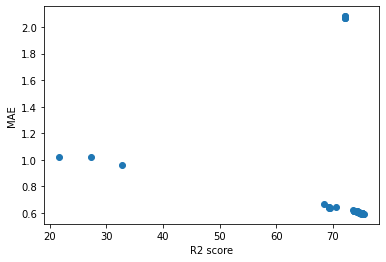

In [ ]:
plt.scatter(log_df['r2-score'], log_df['mae'])
plt.xlabel('R2 score')
plt.ylabel('MAE')

In [ ]:
# We are looking for model with higher r2score and lower mae, cohen kappa is not done yet.
log_df.sort_values(['r2-score', 'mae'], ascending=[False, True])

,modelName,features_list,features_size,hyperparameters,scaling_type,no_of_kfolds,comments,r2-score,mae,cohen_kappa_score
48,Gradient Boosting Regression,"Index(['Sent_Count', 'Word_Count', 'Char_Count...",10,"('none',)","('none',)","(0,)",Gradient Boosting Regression Model with SFS,75.492269,0.591649,0.386560
46,Gradient Boosting Regression,"Index(['Sent_Count', 'Char_Count', 'Avg_Word_C...",8,"('none',)","('none',)","(0,)",Gradient Boosting Regression Model with SFS,75.423652,0.593549,0.372768
52,Gradient Boosting Regression,"Index(['Sent_Count', 'Char_Count', 'Avg_Word_C...",14,"('none',)","('none',)","(0,)",Gradient Boosting Regression Model with SFS,75.387734,0.592596,0.370215
49,Gradient Boosting Regression,"Index(['Sent_Count', 'Char_Count', 'Avg_Word_C...",11,"('none',)","('none',)","(0,)",Gradient Boosting Regression Model with SFS,75.355324,0.594490,0.380086
56,Gradient Boosting Regression,"Index(['Sent_Count', 'Word_Count', 'Char_Count...",18,"('none',)","('none',)","(0,)",Gradient Boosting Regression Model with SFS,75.259716,0.596713,0.366623
...,...,...,...,...,...,...,...,...,...,...
35,Random Forest Regressor,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",26,"('none',)","('none',)","(0,)",Random Forest Regressor with SFS,69.368817,0.640225,0.369261
41,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",110,"('none',)","('none',)","(0,)",Vanilla Linear Regression Model with only W2V ...,68.483510,0.662999,0.232279
37,Lasso Regression,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",100,"{'lasso_regression__alpha': 0.0001, 'polynomia...","('none',)",3,Lasso Regression + GridSearchCV + Only W2V Fea...,32.774517,0.961026,0.128305
36,Linear Regression,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",100,"('none',)","('none',)","(0,)",Vanilla Linear Regression Model with only W2V ...,27.374415,1.023483,0.112845


### **Training and Testing on Best Model** 

In [ ]:
#Gradient Boosting Algorithm with Top 10 Features
y_col = "Total Score"
X = df_train[['Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count',
       'pNoun_Count', 'Count_Comma', 'Flesch_Reading_Ease_Score',
       'Dale_Challl_Readability_Score', 'Lexical_Diversity',
       'Lexical_Originality']]
y = df_train[y_col]


data_logger = Logger_Regression("Gradient Boosting Regression", X.columns, len(X.columns))
data_logger.set_comment("Gradient Boosting Regression Model with SFS")
model = data_logger.gbr_basic(X,y)

Mean Absolute Error of Gradient Boosting Regression Model with SFS  0.594 
R2 score of Gradient Boosting Regression Model with SFS :75.384
Cohen Kappa score Gradient Boosting Regression Model with SFS : 0.385


In [ ]:
with open('model01.pkl', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
# Testing set
df_test = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/TestSet01_Features.csv", index_col =[0])
df_test.head()

,essay_id,essay_set,Essay,domain1_predictionid,predicted_score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Count_Comma,Count_Questionmark,Count_Hyphens,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",1788,7,13,275,1365,4.138182,21.153846,...,21,1,0,84.459119,4.143293,6.695367,103,0.374545,154,0.000417
1,1789,1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,1789,8,20,353,1605,3.671388,17.650000,...,1,0,0,90.659627,2.564512,5.719674,133,0.376771,218,0.000538
2,1790,1,"Dear Local newspaper, Have you been spending a...",1790,9,15,471,2343,4.040340,31.400000,...,6,2,0,69.169096,9.159993,6.836636,161,0.341826,289,0.000652
3,1791,1,"Dear Readers, @CAPS1 you imagine how life woul...",1791,9,24,410,1981,3.958537,17.083333,...,8,5,0,92.721270,2.346815,6.178370,127,0.309756,230,0.000514
4,1792,1,"Dear newspaper, I strongly believe that comput...",1792,9,34,496,2517,4.163306,14.588235,...,9,0,0,83.890038,0.913899,6.206488,161,0.324597,318,0.000652


In [ ]:
y_col = "predicted_score"
X = df_test[['Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count',
       'pNoun_Count', 'Count_Comma', 'Flesch_Reading_Ease_Score',
       'Dale_Challl_Readability_Score', 'Lexical_Diversity',
       'Lexical_Originality']]
y = df_test[y_col]


In [ ]:
#Loading model from file
with open('model01.pkl', 'rb') as f:
  model = pickle.load(f)

In [ ]:
#predicting results on test set
y_test_pred = model.predict(X)
y_test_pred = np.floor(y_test_pred)
r2_score_test = r2_score(y,y_test_pred)*100
mae_test = mean_absolute_error(y,y_test_pred)
print("Mean Absolute Error is  %.3f" %mae_test)
print("R2 score is : %.3f" %r2_score_test)


#Scores on np.rint: Mean Absolute Error is  0.871, R2 score is : 38.800
#Scores on np.floor: Mean Absolute Error is  0.435 , R2 score is : 73.758

Mean Absolute Error is  0.435
R2 score is : 73.758


In [ ]:
df = pd.DataFrame({'Actual': y, 'Predicted': y_test_pred})

# Print the DataFrame as a string
print(df.to_string())

     Actual  Predicted
0         7        8.0
1         8        8.0
2         9        9.0
3         9        9.0
4         9       10.0
5         9       10.0
6         9        9.0
7        11       10.0
8         8        8.0
9        10       10.0
10        8        9.0
11        9       10.0
12        8        8.0
13       12       10.0
14        7        7.0
15        8       10.0
16        8        9.0
17        9       10.0
18        8        8.0
19        8        8.0
20        9        9.0
21        9        9.0
22       11       10.0
23       10       10.0
24        9        9.0
25        8        8.0
26        8        7.0
27        8        9.0
28        9        9.0
29        8        8.0
30        9        9.0
31        8        8.0
32        9        9.0
33        5        7.0
34        9       10.0
35       11       10.0
36       10       11.0
37        8        9.0
38        9       10.0
39        7        7.0
40       11       10.0
41        8        9.0
42       11